In [24]:
pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.6 MB/s eta 0:00:00


In [25]:
import os
import requests
import pandas as pd
import time
import logging
from tqdm import tqdm
from datetime import datetime
# from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 환경변수 로드
# load_dotenv()

In [10]:
# 로깅 설정
def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(f'shopping_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

# 데이터 수집 진행상황 모니터링 클래스
class DataCollectionMonitor:
    def __init__(self, total_requests):
        self.total_requests = total_requests
        self.current_request = 0
        self.start_time = time.time()
        self.progress_bar = tqdm(total=total_requests, desc="데이터 수집 진행률")

    def update(self):
        self.current_request += 1
        self.progress_bar.update(1)

    def get_progress(self):
        return (self.current_request / self.total_requests) * 100

    def get_elapsed_time(self):
        return time.time() - self.start_time

    def close(self):
        self.progress_bar.close()

# API 요청
def fetch_data(client_id, client_secret, url, categories, start_date, end_date, time_unit, devices, genders, ages, logger):
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret,
        "Content-Type": "application/json"
    }
    all_results = []

    # 총 요청 횟수 계산
    total_requests = len(devices) * len(genders) * len(ages) * len(categories)
    monitor = DataCollectionMonitor(total_requests)

    for device in devices:
        for gender in genders:
            for age_group in ages:
                for category in categories:
                    logger.info(f"수집 중: {device}-{gender}-{age_group}-{category['name']}")

                    body = {
                        "startDate": start_date,
                        "endDate": end_date,
                        "timeUnit": time_unit,
                        "category": [category],
                        "device": device,
                        "gender": gender,
                        "ages": [age_group]
                    }

                    try:
                        response = requests.post(url, headers=headers, json=body)
                        if response.status_code == 200:
                            data = response.json()
                            for category_data in data["results"]:
                                for data_point in category_data["data"]:
                                    all_results.append({
                                        "date": data_point["period"],
                                        "category": category["name"],
                                        "device": device,
                                        "gender": gender,
                                        "age_group": age_group,
                                        "ratio": data_point["ratio"]
                                    })
                            logger.info(f"성공: {category['name']} 데이터 수집 완료")
                        else:
                            logger.error(f"API 요청 실패: {category['name']}, 상태 코드: {response.status_code}")

                    except Exception as e:
                        logger.error(f"에러 발생: {str(e)}")

                    monitor.update()

                    # API 호출 간격 조절 (초당 요청 제한 고려)
                    time.sleep(0.1)

    monitor.close()
    logger.info(f"총 소요시간: {monitor.get_elapsed_time():.2f}초")

    return pd.DataFrame(all_results)

In [32]:
# 로거 설정
logger = setup_logging()
logger.info("프로그램 시작")

# 설정값 정의
CATEGORIES = [
    {"name": "패션의류", "param": ["50000000"]},
    {"name": "화장품/미용", "param": ["50000002"]},
    {"name": "디지털/가전", "param": ["50000003"]},
    {"name": "가구/인테리어", "param": ["50000004"]},
    {"name": "출산/육아", "param": ["50000005"]},
    {"name": "스포츠/레저", "param": ["50000006"]},
    {"name": "생활/건강", "param": ["50000007"]},
    {"name": "여가/생활편의", "param": ["50000008"]},
    {"name": "식품", "param": ["50000009"]},
    {"name": "도서", "param": ["50000010"]}
]

START_DATE = "2024-11-01"
END_DATE = "2024-12-15"
TIME_UNIT = "date"
DEVICES = ["pc", "mobile"]
GENDERS = ["f", "m"]
AGES = ["10", "20", "30", "40", "50", "60"]


# 환경변수에서 API 키 로드

# CLIENT_ID = os.getenv("CLIENT_ID")
# CLIENT_SECRET = os.getenv("CLIENT_SECRET")
URL = "https://openapi.naver.com/v1/datalab/shopping/categories"

if not CLIENT_ID or not CLIENT_SECRET:
    logger.error("CLIENT_ID 또는 CLIENT_SECRET이 설정되지 않았습니다. .env 파일을 확인하세요.")
    exit(1)


try:
    # 데이터 수집
    logger.info("데이터 수집 시작")
    df = fetch_data(
        CLIENT_ID, CLIENT_SECRET, URL, CATEGORIES,
        START_DATE, END_DATE, TIME_UNIT,
        DEVICES, GENDERS, AGES,
        logger
    )

    if not df.empty:
        # 원본 데이터 저장
        df.to_csv("raw_shopping_data.csv", index=False)
        logger.info("원본 데이터 저장 완료")

        # 전처리된 데이터 저장
        df.to_csv("processed_shopping_data.csv", index=False)
        logger.info("전처리된 데이터 저장 완료")

    else:
        logger.error("수집된 데이터가 없습니다.")

except Exception as e:
    logger.error(f"프로그램 실행 중 오류 발생: {str(e)}")

finally:
    logger.info("프로그램 종료")

데이터 수집 진행률:   2%|▏         | 5/240 [00:04<03:32,  1.10it/s]

KeyboardInterrupt: 

In [14]:
df = pd.read_csv('raw_shopping_data.csv')
df

,date,category,device,gender,age_group,ratio
0,2024-11-01,패션의류,pc,f,10,57.48792
1,2024-11-02,패션의류,pc,f,10,49.75845
2,2024-11-03,패션의류,pc,f,10,50.72463
3,2024-11-04,패션의류,pc,f,10,88.88888
4,2024-11-05,패션의류,pc,f,10,89.37198
...,...,...,...,...,...,...
4855,2024-12-11,식품,pc,m,60,85.94787
4856,2024-12-12,식품,pc,m,60,65.40623
4857,2024-12-13,식품,pc,m,60,73.17322
4858,2024-12-14,식품,pc,m,60,33.21410


In [15]:
# 데이터 전처리
logger.info("데이터 전처리 시작")

# 결측치 확인
missing_values = df.isnull().sum()
logger.info(f"결측치 현황:\n{missing_values}")

# 이상치 확인 (ratio 값이 0-100 범위를 벗어나는 경우)
outliers = df[~df['ratio'].between(0, 100)]
logger.info(f"이상치 개수: {len(outliers)}")

# 데이터 타입 변환
df['date'] = pd.to_datetime(df['date'])
df['age_group'] = df['age_group'].astype(int)

# 기초 통계량 출력
logger.info("\n기초 통계량:")
logger.info(f"\n{df.describe()}")

In [16]:
# 데이터 타입 변환 및 날짜 관련 컬럼 생성
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek

df['dayofweekname'] = df['dayofweek'].map(lambda x: '월화수목금토일'[x])

In [17]:
df.describe()

,date,age_group,ratio,month,dayofweek
count,4860,4860.000000,4860.000000,4860.000000,4860.000000
mean,2024-11-23 00:00:00,35.000000,62.812776,11.333333,3.133333
min,2024-11-01 00:00:00,10.000000,2.434070,11.000000,0.000000
25%,2024-11-12 00:00:00,20.000000,40.637577,11.000000,1.000000
50%,2024-11-23 00:00:00,35.000000,68.675075,11.000000,3.000000
75%,2024-12-04 00:00:00,50.000000,83.403652,12.000000,5.000000
max,2024-12-15 00:00:00,60.000000,100.000000,12.000000,6.000000
std,NaN,17.080009,24.630375,0.471453,2.006862


Text(0.5, 1.0, '카테고리별 평균 비율')

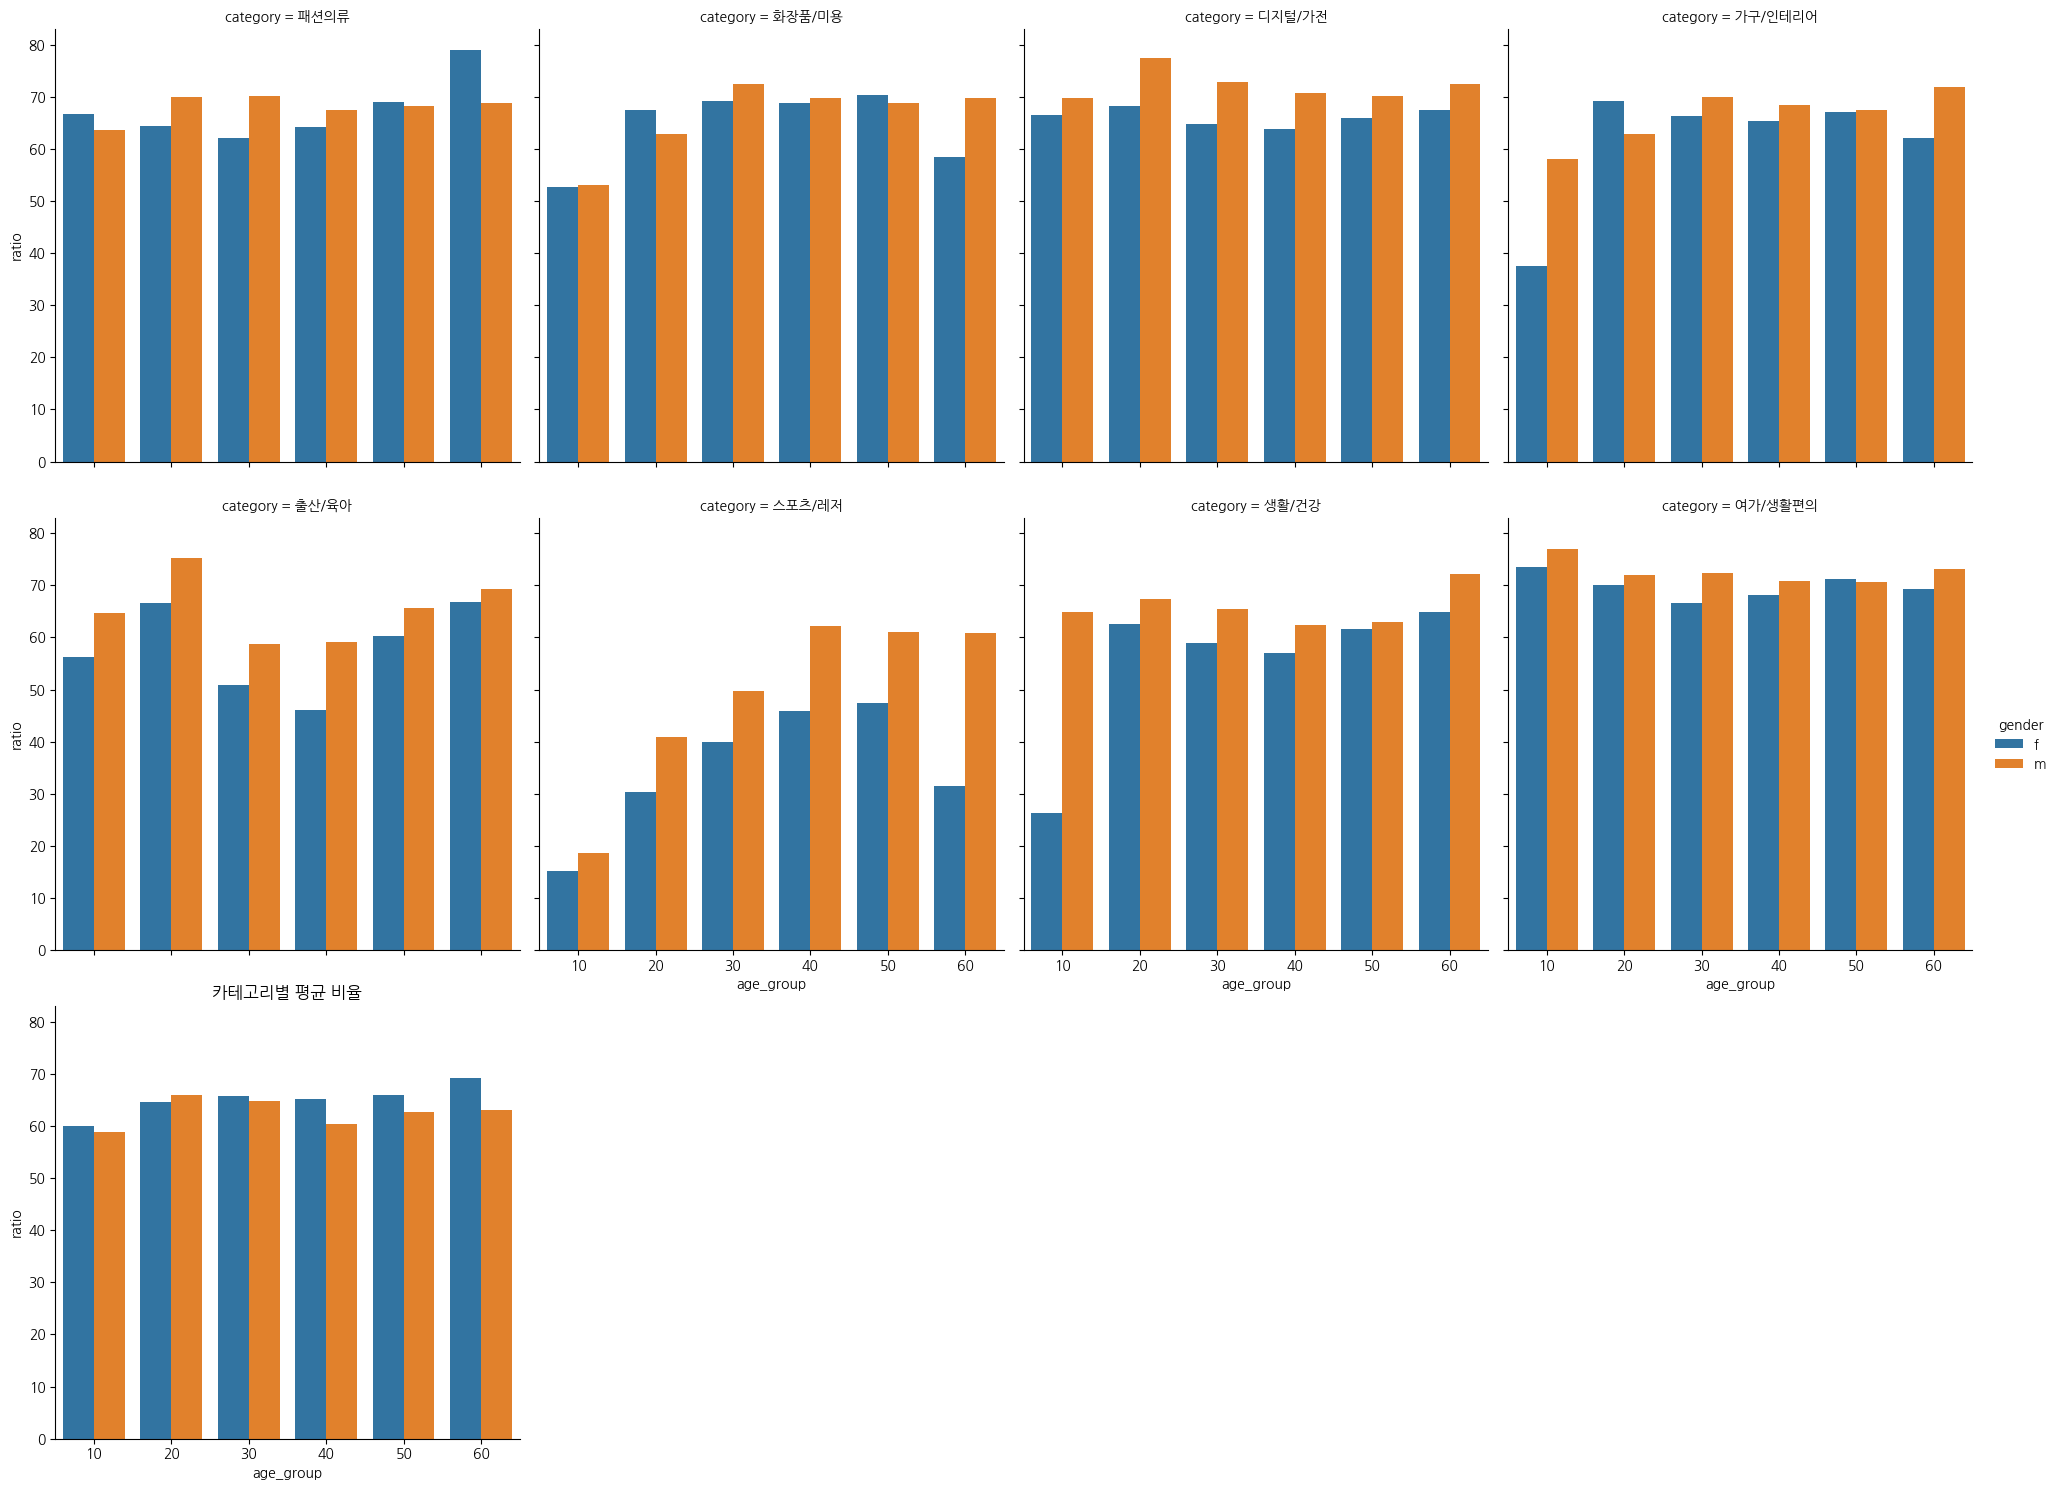

In [27]:
sns.catplot(x='age_group', y='ratio', data=df, errorbar=None,
            kind='bar', hue='gender', col='category', col_wrap=4)
plt.title('카테고리별 평균 비율')

In [42]:
import requests
import json
import pandas as pd

def fetch_shopping_insight(client_id, client_secret, start_date, end_date, time_unit, category_id, device=None, gender=None, ages=None):
    url = "https://openapi.naver.com/v1/datalab/shopping/categories"

    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret,
        "Content-Type": "application/json"
    }

    payload = {
        "startDate": start_date,
        "endDate": end_date,
        "timeUnit": time_unit,
        "category": [{"name": "골프웨어", "param": [category_id]}],
    }

    if device:
        payload["device"] = device
    if gender:
        payload["gender"] = gender
    if ages:
        payload["ages"] = ages

    response = requests.post(url, headers=headers, data=json.dumps(payload))

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"API 요청 실패: {response.status_code}, {response.text}")

# 네이버 API 키
# CLIENT_ID = "YOUR_CLIENT_ID"
# CLIENT_SECRET = "YOUR_CLIENT_SECRET"

# 파라미터 설정
start_date = "2023-01-01"
end_date = "2024-12-01"
time_unit = "week"
category_id = "50000544"  # 골프웨어 카테고리 ID 예시
device = ["pc", 'mobile']
gender = ["f","m"]
ages = ["20", "30", "40"]

# 데이터 요청
try:
    data = fetch_shopping_insight(CLIENT_ID, CLIENT_SECRET, start_date, end_date, time_unit, category_id, device, gender, ages)
    print(json.dumps(data, indent=4, ensure_ascii=False))

    # pandas로 데이터 프레임 변환
    df = pd.DataFrame(data['results'][0]['data'])
    print(df)
except Exception as e:
    print(e)

{
    "startDate": "2023-01-01",
    "endDate": "2024-12-21",
    "timeUnit": "month",
    "results": [
        {
            "title": "골프웨어",
            "category": [
                "50000544"
            ],
            "data": [
                {
                    "period": "2023-01-01",
                    "ratio": 50.49937
                },
                {
                    "period": "2023-02-01",
                    "ratio": 45.81772
                },
                {
                    "period": "2023-03-01",
                    "ratio": 71.00499
                },
                {
                    "period": "2023-04-01",
                    "ratio": 81.61672
                },
                {
                    "period": "2023-05-01",
                    "ratio": 99.1573
                },
                {
                    "period": "2023-06-01",
                    "ratio": 100
                },
                {
                    "period": "2023-07-01

In [43]:
df

,period,ratio
0,2023-01-01,50.49937
1,2023-02-01,45.81772
2,2023-03-01,71.00499
3,2023-04-01,81.61672
4,2023-05-01,99.15730
5,2023-06-01,100.00000
6,2023-07-01,90.35580
7,2023-08-01,83.23970
8,2023-09-01,54.80649
9,2023-10-01,59.76903


In [44]:
# prompt: df DataFrame 사용: suggest a plot

import altair as alt

# Convert 'period' column to datetime objects
df['period'] = pd.to_datetime(df['period'])

# Create a line chart
alt.Chart(df).mark_line().encode(
    x='period',
    y='ratio'
).properties(title='Ratio Over Time')

데이터 수집 진행률:   2%|▏         | 5/240 [11:52<9:17:53, 142.44s/it]


alt.Chart(...)